# Kohonen Self-Organising Map Challenge

## Preamble

In [1]:
# Would greatly appreciate the Jupyter team making foldable cells a built-in feature.

from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr

from som import Animator, create_som

# Convenience function for random number control.
def rng():
    return nr.default_rng(20200101)

# matplotlib configuration
plt.ioff()

plt.rcParams['animation.html'] = 'html5'
plt.rcParams['animation.embed_limit'] = 30

# Input data generation.
input_data = np.random.random((20, 3))

# Canned self-organising map and training regime arguments.
grid_10_kwargs = dict(width=10, height=10)
grid_100_kwargs = dict(width=100, height=100)

regime_100_kwargs = dict(max_iterations=100)
regime_200_kwargs = dict(max_iterations=200)
regime_500_kwargs = dict(max_iterations=500)
regime_1000_kwargs = dict(max_iterations=1000)

# Convenience function for static figures of created self-organising maps.
def static(
    grid_kwargs,
    regime_kwargs,
    visualisation=None,
    threshold_nbhood=False
):
    animator = Animator(
        visualisation=visualisation,
        input_data=input_data if visualisation else None
    )
    animator.frame(create_som(
        rng(),
        input_data,
        grid_kwargs,
        regime_kwargs,
        threshold_nbhood=threshold_nbhood
    ))
    plt.show()

# Convenience function for animated figures of created self-organising maps.
def animated(
    grid_kwargs,
    regime_kwargs,
    iteration_interval=10,
    threshold_nbhood=False,
    visualisation=None
):
    data = input_data if visualisation else None
    animator = Animator(
        iteration_interval=iteration_interval,
        visualisation=visualisation,
        # Non-consequential for the weights visualisation
        input_data=input_data
    )
    create_som(
        rng(),
        input_data,
        grid_kwargs,
        regime_kwargs,
        threshold_nbhood=threshold_nbhood,
        callback=animator
    )
    video = HTML(animator.animate().to_jshtml())
    plt.close()
    return video

## Implementation

The self-organising map implementation (for grid maps) can be found in the file `som.py`. The map can be configured for neighbourhood thresholding, in which nodes outside the neighbourhood radius of the best matching unit do not have their weights updated. The alternative is that nodes are implicitly excluded by substantially reduced influence for distances beyond the neighbhourhood radius. This document presents maps generated using the latter approach unless otherwise stated. The implementation depends heavily on numpy and its vectorisation capabilities for acceptable performance. Note that execution timings include map creation and performance-related precalculations. As the random state is reset for each training process and the input data remains fixed, experiments can be directly compared and the same process should proceed for each same combination of map size, iterations and thresholding.

## 10x10 map, 100 iterations

### Static

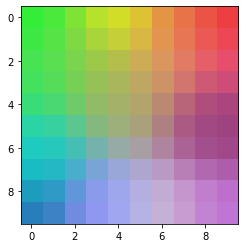

CPU times: user 2.52 s, sys: 5.8 ms, total: 2.53 s
Wall time: 2.52 s


In [2]:
%%time

static(grid_10_kwargs, regime_100_kwargs)

### Animated

In [3]:
animated(grid_10_kwargs, regime_100_kwargs)

### Animated with Thresheld Neighbourhood

The below is a repeat of the above training with neighbourhood thresholding enabled. The borders between regions are slightly 'harsher' using this approach than without thresholding, where nodes affect each other at larger distances (but reduced influence).

In [4]:
animated(grid_10_kwargs, regime_100_kwargs, threshold_nbhood=True)

## 10x10 map, 200 iterations

### Static

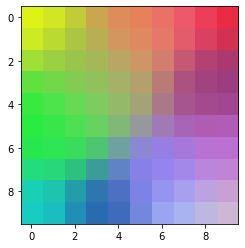

CPU times: user 4.72 s, sys: 18 ms, total: 4.74 s
Wall time: 4.73 s


In [5]:
%%time

static(grid_10_kwargs, regime_200_kwargs)

### Animated

In [6]:
animated(grid_10_kwargs, regime_200_kwargs)

## 10x10 map, 500 iterations

### Static

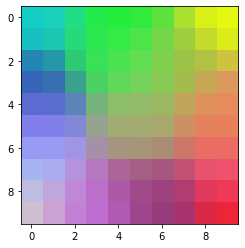

CPU times: user 11.3 s, sys: 10.9 ms, total: 11.3 s
Wall time: 11.3 s


In [7]:
%%time

static(grid_10_kwargs, regime_500_kwargs)

### Animated

In [8]:
animated(grid_10_kwargs, regime_500_kwargs)

## 100x100 map, 1000 iterations

### Static

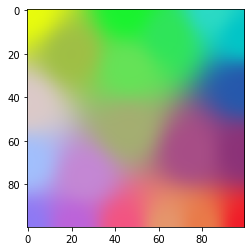

CPU times: user 30min 54s, sys: 4.86 s, total: 30min 59s
Wall time: 30min 53s


In [9]:
%%time

static(grid_100_kwargs, regime_1000_kwargs)

### Animated

In [10]:
animated(grid_100_kwargs, regime_1000_kwargs, iteration_interval=25)

### Animated with Thresheld Neighbourhood

In [11]:
animated(grid_100_kwargs, regime_1000_kwargs, iteration_interval=25, threshold_nbhood=True)

## Remarks on Model Behaviour

Kohonen and Hokela observe [http://www.scholarpedia.org/article/Kohonen_network] regarding self-organising maps:

> Different learning processes will be obtained when starting with different initial values mi(1) , and applying different sequences of the training vectors x(t) and different learning parameters.

In particular, the training process is greedy by way of selecting a best matching unit and influencing only those nodes in its vicinity. The duration of training (maximum number of iterations) defines the progression of fitting, initially starting with relatively substantial updates for each input vector due to a relatively high learning rate and neighbourhood radius, and finishing with relatively small, localised updates. For small numbers of iterations, the map may become trapped in suboptimal states as the neighbourhood and learning rate become small. However, when using a prescribed number of iterations rather than a stopping criterion, the risk exists that unnecessary computation will be performed in iterations after the map has reached a stable state. This may be more clearly seen in the figure below which shows the node activations for the input data for a map trained over 500 iterations. This map has arranged nodes such that colours that are similar in the RGB colour space (in which the input data and weights lie) are near together in the map.

In [12]:
animated(grid_10_kwargs, regime_500_kwargs, visualisation='best_units')

## Remarks on Implementation Performance

The timings in this document are provided by Jupyter Notebook's cell execution time mechanism and should not be relied upon as this is not a representative runtime environment for many use cases and the benchmarking rigour is poor (sample of one). Repeated executions in a controlled runtime environment are necessary to gain a solid understanding of the performance. The algorithmic complexity of this implementation of the Kohonen self-organising map is approximately *O(nmid)* where n is the width of the map, m is the height, i is the number of iterations and d is the number of input vectors. This is approximately borne out by the experiments in this notebook, e.g. it can be seen that the execution time of the 10x10 node maps is directly proportional to the number of iterations. As such, the 100x100 node maps take a substantially longer time to train, with each iteration involving approximately as many operations as 100 iterations of a 10x10 node map. Effort has been made to make the per-iteration execution time as short as possible, primarily by exploiting numpy's vectorisation capabilities.

As the neighbourhood distance only includes a few nodes late in the training process, it may be possible to greatly speed up training when the number of iterations is large by using space culling or indexing (both in the weight space) techniques to limit the number of nodes processed per iteration-vector update. Profiling indicates that identifying the best matching unit for an input vector is where much of the execution time is spent in this implementation, which suggests spatial culling would be highly effective. Given the extent that weights are updated per iteration late in the training process, it may also be likely that best matching units for an input vector will be close together (or identical) in the input space for consecutive iterations. This might inform the local area of the previous best matching unit to search and assist avoiding the evaluation of the entire weight matrix. Care with any such method is necessary to avoid ignoring the actual best matching unit, however, and such methods have not been explored in this work.

More generally, the execution time for useful Kohonen maps in practice may be reduced by intelligently selecting initial weights and terminating the process once a criterion for stability has been met. The 'batch map' variant algorithm also exists, whereby nodes are shifted according to the average of the input vectors that share the same best matching unit. This is useful when the number of training examples is larger than the number of nodes in the map, as the map's size then effectively sets the per iteration execution time (other considerations notwithstanding). Beyond these considerations, the choice of hardware configuration, processing unit type (i.e. CPU vs GPU), whether specific processing units are targeted, and parallelisation (using modified SOM algorithms) are all performance factors but beyond the scope of this work.